BlockSeparation+NonLinearEncoder+**LocationEmbedding**+UNetdecoder

**Variable:Compression Ratio**

4*4kernel,1:8,
Completed

In [15]:
import torch#
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt 
import sys
import time
import pandas as pd
import os
import csv

from skimage.metrics import structural_similarity as ssim_loss

In [16]:

from datetime import datetime
now = datetime.now()
formatted_date = now.strftime("%m%d")
formatted_date = int(formatted_date)
print(formatted_date)

import os
home_directory = os.path.expanduser('~')
onedrive_folder_name = 'OneDrive'
onedrive_path = os.path.join(home_directory, onedrive_folder_name)
save_directory = os.path.join(onedrive_path,'CODES', 'konishi_AutoEncoder', 'AutoEncoder_data_pre', 'Cifar10_VCR_CIM-1C_result') #保存先のファイル名を入力
print(save_directory)
os.makedirs(save_directory, exist_ok=True)


201
C:\Users\Scent\OneDrive\CODES\konishi_AutoEncoder\AutoEncoder_data_pre\Cifar10_VCR_CIM-1C_result


In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [19]:
home_directory = os.path.expanduser('~')
onedrive_folder_name = 'OneDrive'
onedrive_path = os.path.join(home_directory, onedrive_folder_name)

root = os.path.join(onedrive_path, 'CODES', 'samples', 'cifar10_data')

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0, 0, 0),  
                         (1, 1, 1)), 
])

cifar10_train = datasets.CIFAR10(root=root, download=True, train=True, transform=transform)
cifar10_test = datasets.CIFAR10(root=root, download=True, train=False, transform=transform)

train_dataloader = DataLoader(cifar10_train, batch_size=128, shuffle=True)
test_dataloader = DataLoader(cifar10_test, batch_size=128, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [20]:
def split_into_kernels(image, kernel_size):
    b,c,h,w = image.shape
    kernels = image.unfold(2, kernel_size, kernel_size).unfold(3, kernel_size, kernel_size)
    kernels = kernels.contiguous().view(b, c, -1, kernel_size, kernel_size)
    kernels = kernels.permute(0, 2, 1, 3, 4)# (b, n_patches, c, kernel_size, kernel_size)
    return kernels

In [21]:
#Encoder5DX(パッチ分割，位置埋め込みを想定)
class Encoder(nn.Module):
    def __init__(self,kernel_size,leverage,channels,alpha=1.2):
        super(Encoder, self).__init__()
        self.kernel_size = kernel_size
        self.leverage = leverage
        self.alpha = alpha

        kernel_in = kernel_size ** 2 * channels
        output_dim = kernel_in // leverage
        phase = torch.rand(output_dim, kernel_in) * 2 * np.pi - np.pi
        modulus = torch.ones(output_dim, kernel_in)
        # modulus = torch.rand(output_dim, kernel_in)

        # 複素数を生成 (r * exp(iθ) = r * (cos(θ) + i*sin(θ)))
        real_part = modulus * torch.cos(phase)
        imag_part = modulus * torch.sin(phase)

        self.B = torch.complex(real_part, imag_part).detach().to(device)
        self.B.requires_grad = False

        #self.ln = nn.LayerNorm(normalized_shape=int(kernel_in/leverage))##

    def forward(self, x):
        b, n_patches, c, k, _ = x.shape# (b, n_patches, c, kernel_size, kernel_size)
        x = x.reshape(b*n_patches, -1)  #(b*p,c*k*k)
        x = 1+torch.exp(1j * self.alpha * x) 
        x = x.T  
        x = torch.matmul(self.B, x).T  #(b*p,c*k*k/l)
        x = torch.abs(x)**2 
        return x, n_patches 
    

In [22]:
class PositionalEmbedder(nn.Module):
    def __init__(self, img_size, kernel_size, pos_embed_dim=8):
        super(PositionalEmbedder, self).__init__()
        self.kernel_size = kernel_size
        self.img_size = img_size
        self.pos_embed_dim = pos_embed_dim

        self.num_patches_x = img_size // kernel_size
        self.num_patches_y = img_size // kernel_size


        self.embed_x = nn.Embedding(self.num_patches_x, self.pos_embed_dim)
        self.embed_y = nn.Embedding(self.num_patches_y, self.pos_embed_dim)

    def forward(self, x, b, n_patches):

       
        patch_ids = torch.arange(n_patches, device=x.device)

        ix = patch_ids % self.num_patches_x
        iy = patch_ids // self.num_patches_x

        pos_x = self.embed_x(ix) 
        pos_y = self.embed_y(iy) 

        pos_info = torch.cat([pos_x, pos_y], dim=1) 
        pos_info = pos_info.unsqueeze(0).expand(b, -1, -1).contiguous().view(b*n_patches, -1)

        x = torch.cat([x, pos_info], dim=1) 
        x = x.view(b, n_patches, -1)
        x = x.view(b, -1)
        return x

In [23]:
class PreBlock(nn.Module):
    """
    Decoderに入る前に、EncoderBの出力をさらに学習的に再マッピングする層。
    例えば: 
     - 少し大きめのfc -> BN/LN -> ReLU
     - or GroupNorm1d, LayerNorm, など
    """
    def __init__(self, in_dim, out_dim, use_ln):
        super().__init__()
        self.fc = nn.Linear(in_dim, out_dim, bias=False)
        self.relu = nn.LeakyReLU(inplace=True)
        self.use_ln = use_ln
        if use_ln:
            self.ln = nn.LayerNorm(out_dim)

    def forward(self, x):
        x = self.fc(x)       # (B, out_dim)
        if self.use_ln:
            x = self.ln(x)
        x = self.relu(x)
        return x


In [24]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        #self.gn1 = nn.GroupNorm(num_groups=8, num_channels=out_channels)
        self.relu = nn.LeakyReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        #self.gn2 = nn.GroupNorm(num_groups=8, num_channels=out_channels)
        if in_channels != out_channels:
            self.shortcut = nn.Conv2d(in_channels, out_channels, 1, bias=False)
        else:
            self.shortcut = None

    def forward(self, x):
        residual = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        if self.shortcut is not None:
            residual = self.shortcut(residual)#outと同じチャンネル数に合わせる
        out += residual#残差接続
        out = self.relu(out)
        return out
    
class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UpBlock, self).__init__()
        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.LeakyReLU(inplace=True)

    def forward(self, x):
        x = self.up(x)
        x = self.bn(x)
        x = self.relu(x)
        return x

class UNetDecoder(nn.Module):
    def __init__(self, num_in,ch,img_size):
        super(UNetDecoder, self).__init__()

        self.ch = ch

        self.map_pic = img_size//4

        self.pre = PreBlock(in_dim=num_in, out_dim=ch*self.map_pic*self.map_pic, use_ln=True)

        #self.fc = nn.Linear(num_in, ch*self.map_pic*self.map_pic)
        self.bottleneck = ResidualBlock(ch,ch,3)
        self.up1 = UpBlock(ch,ch)
        self.res1 = ResidualBlock(ch+ch,ch,3)
        self.up2 = UpBlock(ch,ch)
        self.res2 = ResidualBlock(ch+ch,ch,3)
        self.out_conv = nn.Conv2d(ch+ch, 3, 1, bias=True)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):

        #(b,p*c*k*k/l)
        b = x.size(0)
        x = self.pre(x)
        x = x.view(b, self.ch, self.map_pic, self.map_pic) 
        x0 = self.bottleneck(x)  
        x1 = self.up1(x0) 
        x0_upsampled = F.interpolate(x0, scale_factor=2, mode='nearest') 
        x1 = torch.cat([x1, x0_upsampled], dim=1)
        x1 = self.res1(x1)
        x2 = self.up2(x1)
        x1_up = F.interpolate(x1, scale_factor=2, mode='nearest')
        x2 = torch.cat([x2, x1_up], dim=1)
        x_out = self.out_conv(x2)
        x_out = self.sigmoid(x_out) 
        x_out = x_out.view(b, -1)  
        return x_out#(b,p*c*k*k/l)


In [25]:
class AutoEncoder(nn.Module):
    def __init__(self, img_size,channels, kernel_size, leverage, ch, pos_embed_dim):
        super(AutoEncoder, self).__init__()
        self.kernel_size = kernel_size
        
        self.img_size = img_size
        self.channels = channels
        kernel_in = kernel_size**2
        feat_dim = int(kernel_in*channels/leverage)
        num_patches = (img_size//kernel_size)*(img_size//kernel_size)
        total_dim = num_patches*(feat_dim + 2*pos_embed_dim)
        self.pos_embed_dim = pos_embed_dim

        #self.ln = nn.LayerNorm(normalized_shape=int(kernel_in*channels/leverage))
        
        self.encoder = Encoder(kernel_size,leverage,channels)
        self.pos_embedder = PositionalEmbedder(img_size,kernel_size,pos_embed_dim)  
        self.decoder = UNetDecoder(total_dim, ch, img_size, )
    def forward(self, x):
        x = x.view(x.size(0), self.channels, self.img_size, self.img_size)  
        x = split_into_kernels(x, self.kernel_size) 
        x,n_patches = self.encoder(x) #(b*p,c*k*k/l)
        #x = min_max_scale(x) 
        #x = self.ln(x)
        '''x_max = torch.max(x).item()  # xの最大値
        x_min = torch.min(x).item()  # xの最小値

        # 結果を出力
        print(f"xの最大値: {x_max}")
        print(f"xの最小値: {x_min}")
        '''
        b = x.size(0)//n_patches
        x = self.pos_embedder(x,b,n_patches)#(b,p*c*k*k/l)
        x_reconstructed = self.decoder(x)#(b,p*c*k*k/l)
        return x_reconstructed#(b,p*c*k*k/l)

In [26]:
#CIFAR-10の画像を表示する関数
def show_images(images, labels, title):

    from matplotlib import rcParams  # フォント設定用
    rcParams['font.family'] = 'Times New Roman'
    
    images = images.view(images.size(0), 3, 32, 32)
    fixed_indices = {1: 1, 3: 1, 5: 1,7:1,8:0} 
    selected_classes = [1, 3, 5,7,8]  # airplane, cat, dog
    class_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer',
                    'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
    images = images.numpy()
    images = np.transpose(images, (0, 2, 3, 1))
    mean = np.array([0, 0, 0])
    std = np.array([1, 1, 1])
    images = images * std + mean
    images = np.clip(images, 0, 1) 
    
    num_classes = len(selected_classes)
    fig, axes = plt.subplots(1, num_classes, figsize=(10,4))
    
    for i, cls in enumerate(selected_classes):
        matching_indices = (labels == cls).nonzero(as_tuple=True)[0]
        if cls in fixed_indices:
            fixed_index = fixed_indices[cls]
            if fixed_index < len(matching_indices):
                img_idx = matching_indices[fixed_index]
                img = images[img_idx]
                ax = axes[i] if num_classes > 1 else axes
                ax.imshow(img)
                ax.axis('off')
            else:
                print(f"クラス {class_names[cls]} に指定されたインデックス {fixed_index} が見つかりません。")
        else:
            print(f"クラス {class_names[cls]} の固定インデックスが指定されていません。")
    plt.subplots_adjust(wspace=0.05)
    plt.suptitle(title,fontsize=30,y=0.8)


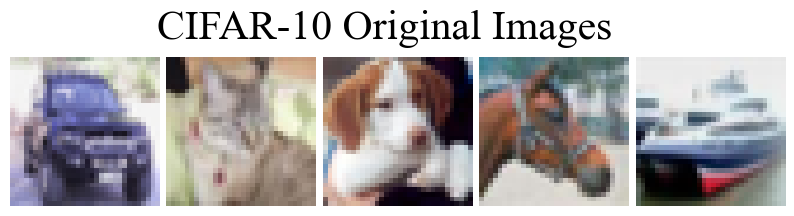

In [27]:

for test_images, test_labels in test_dataloader:
    show_images(test_images, test_labels, title="CIFAR-10 Original Images")  
    break
plt.show()

1:2 1th Epoch: 29/30

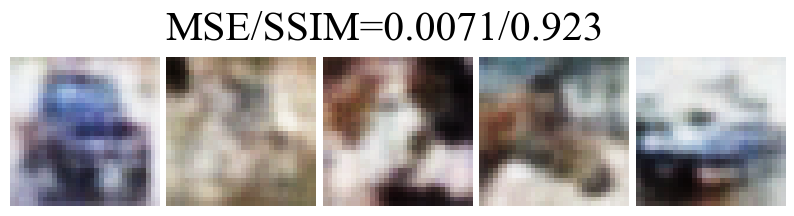

1:2 2th Epoch: 29/30

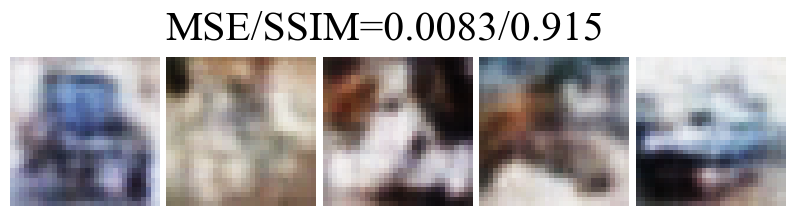

1:2 3th Epoch: 29/30

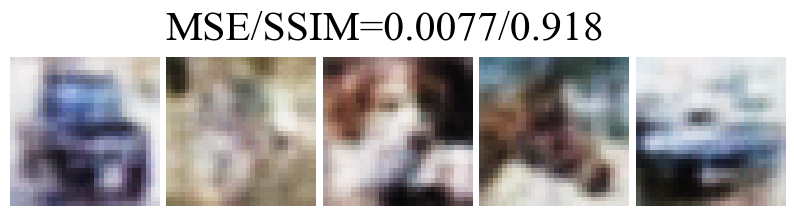

1:2 4th Epoch: 29/30

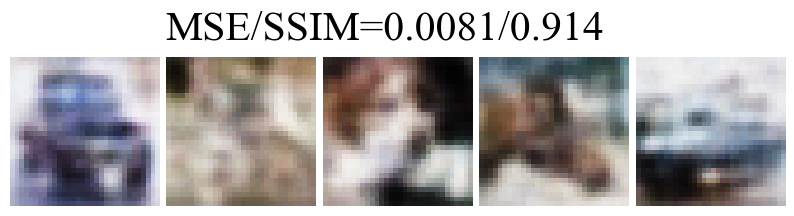

1:2 5th Epoch: 29/30

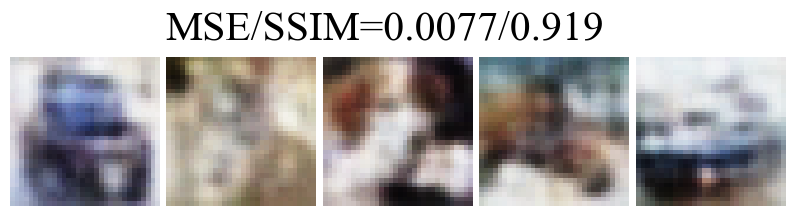

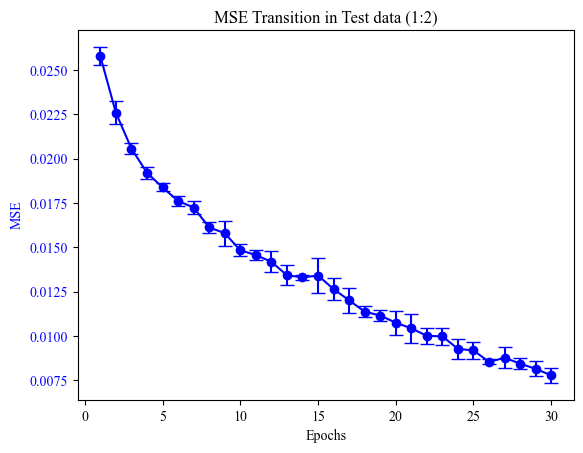

1:4 1th Epoch: 0/30

   Ratio Metrics   Average  Best ID      Best  Worst ID     Worst
0  (1:2)    SSIM  0.917878        1  0.923235         4  0.914433
1  (1:2)     MSE  0.007786        1  0.007108         2  0.008341
     Index  Processing Time
0        1       720.053926
1        2       707.686549
2        3       722.257802
3        4       700.725355
4        5       697.116397
   Average       709.568006


1:4 1th Epoch: 29/30

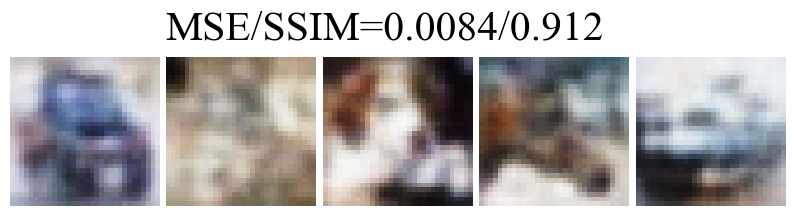

1:4 2th Epoch: 29/30

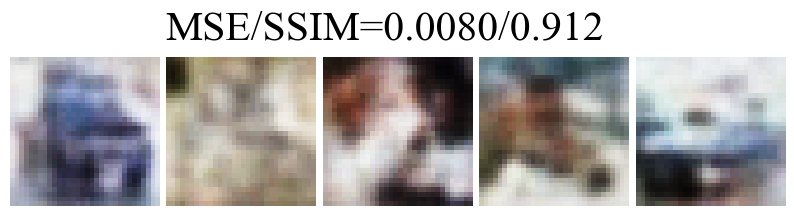

1:4 3th Epoch: 29/30

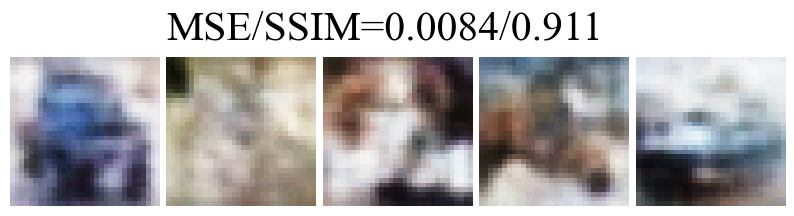

1:4 4th Epoch: 29/30

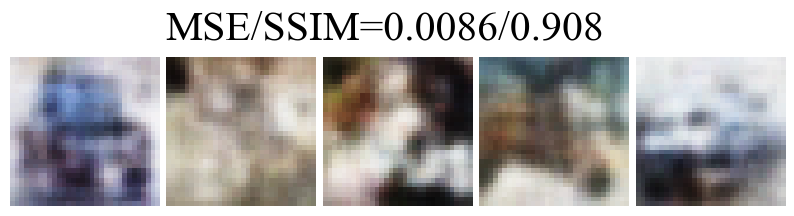

1:4 5th Epoch: 29/30

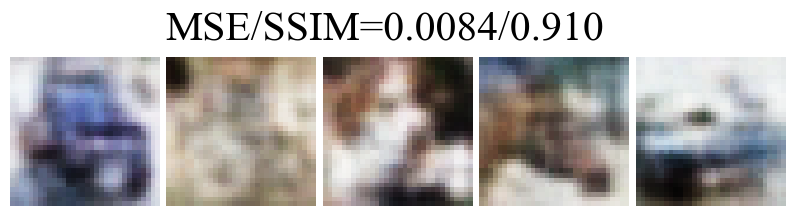

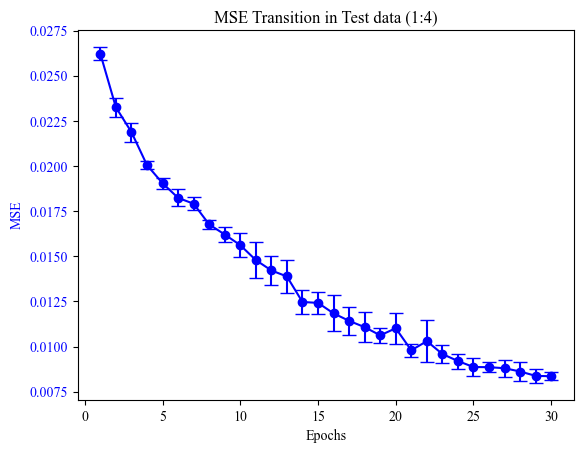

1:8 1th Epoch: 0/30

   Ratio Metrics   Average  Best ID      Best  Worst ID     Worst
0  (1:4)    SSIM  0.910779        2  0.912442         4  0.907613
1  (1:4)     MSE  0.008354        2  0.007963         4  0.008637
     Index  Processing Time
0        1       699.211301
1        2       701.665778
2        3       698.422315
3        4       699.097830
4        5       713.175788
   Average       702.314602


1:8 1th Epoch: 29/30

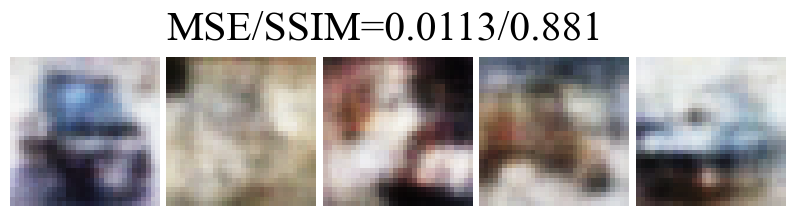

1:8 2th Epoch: 29/30

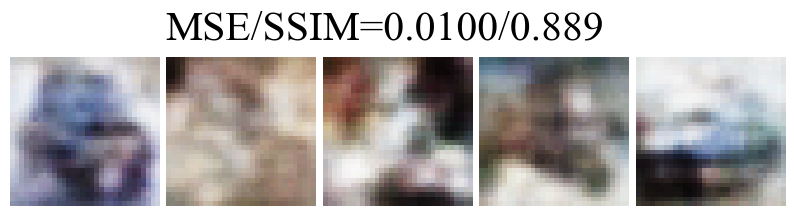

1:8 3th Epoch: 29/30

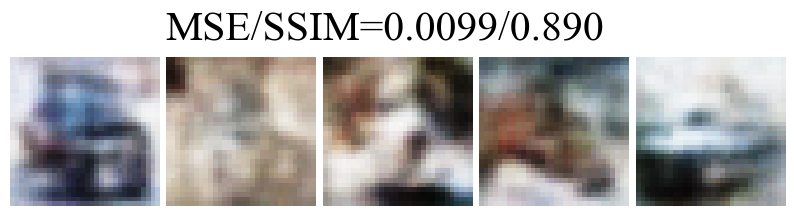

1:8 4th Epoch: 29/30

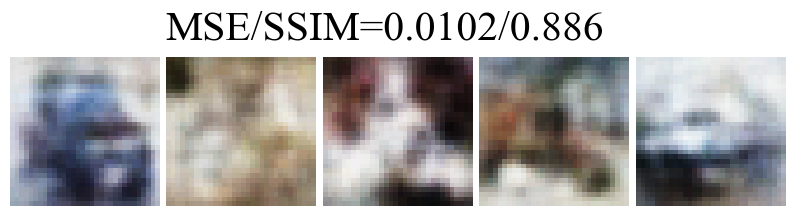

1:8 5th Epoch: 29/30

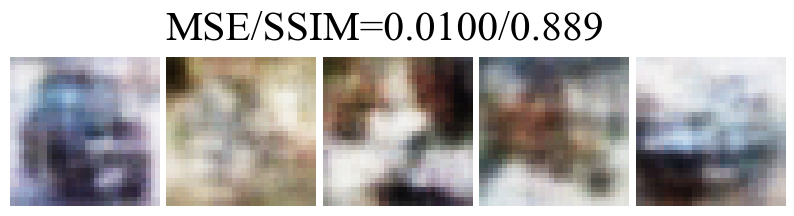

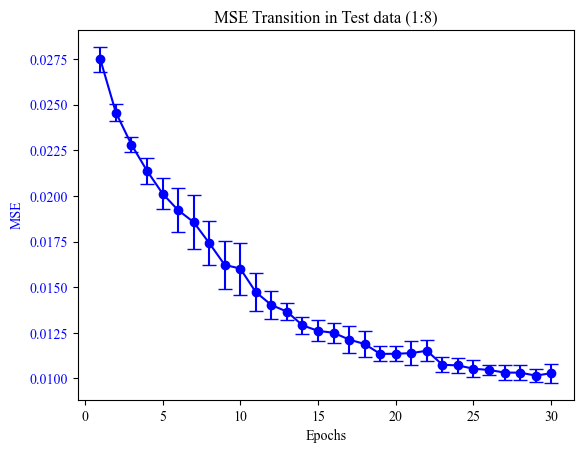

1:12 1th Epoch: 0/30

   Ratio Metrics   Average  Best ID      Best  Worst ID     Worst
0  (1:8)    SSIM  0.886709        3  0.889866         1  0.880579
1  (1:8)     MSE  0.010287        3  0.009935         1  0.011336
     Index  Processing Time
0        1       785.565554
1        2       766.155328
2        3       818.187812
3        4       710.632382
4        5       696.930565
   Average       755.494328


1:12 1th Epoch: 29/30

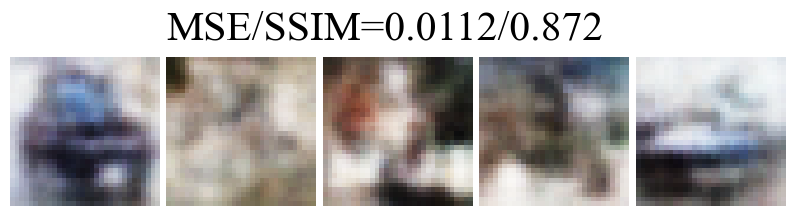

1:12 2th Epoch: 29/30

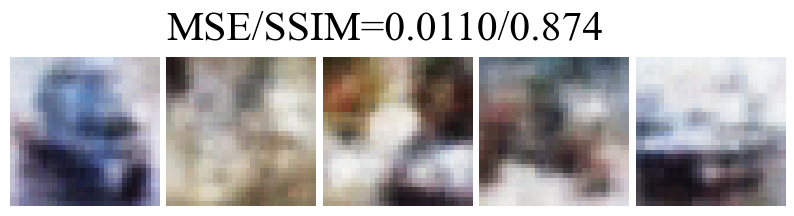

1:12 3th Epoch: 29/30

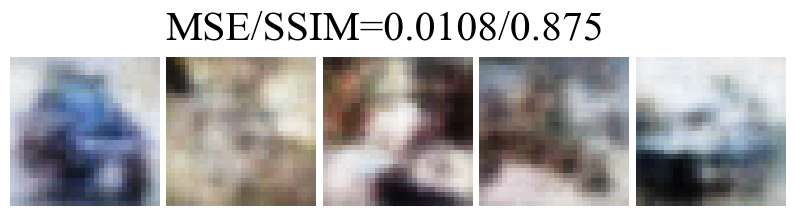

1:12 4th Epoch: 29/30

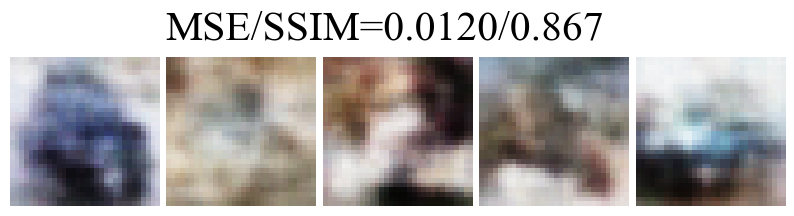

1:12 5th Epoch: 29/30

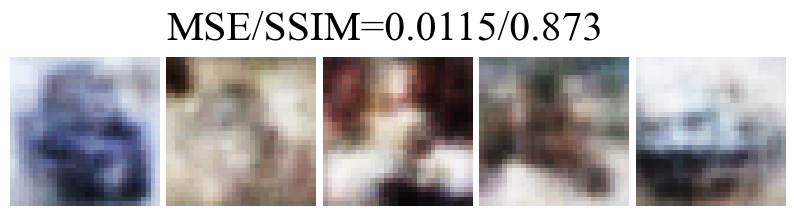

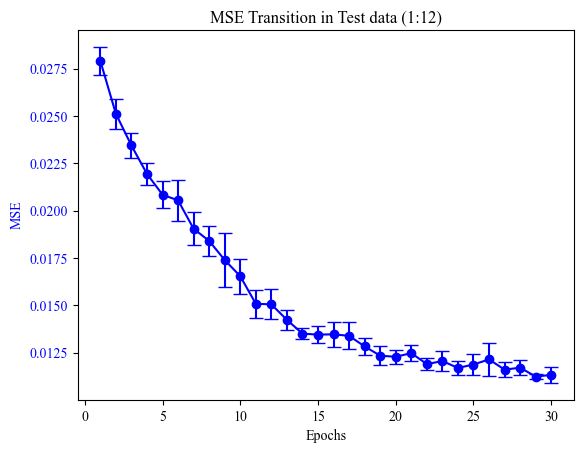

1:16 1th Epoch: 0/30

    Ratio Metrics   Average  Best ID      Best  Worst ID     Worst
0  (1:12)    SSIM  0.872050        3  0.874799         4  0.866912
1  (1:12)     MSE  0.011329        3  0.010818         4  0.012039
     Index  Processing Time
0        1       693.238659
1        2       698.092677
2        3       688.942098
3        4       690.885247
4        5       691.332080
   Average       692.498152


1:16 1th Epoch: 29/30

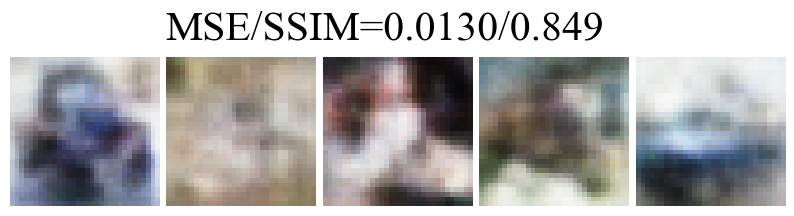

1:16 2th Epoch: 29/30

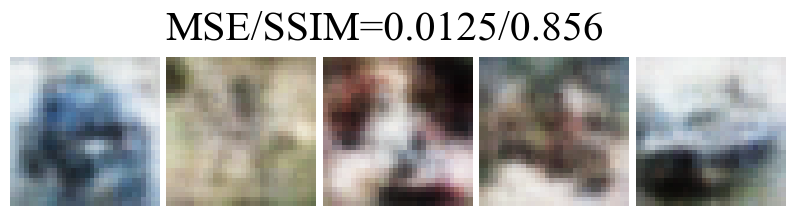

1:16 3th Epoch: 29/30

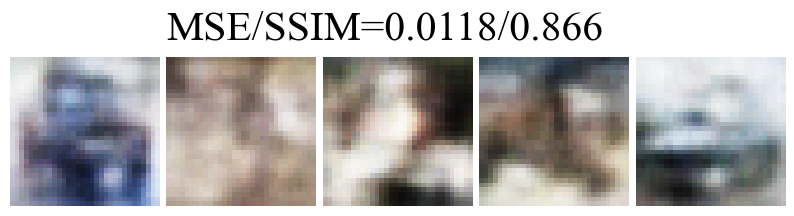

1:16 4th Epoch: 29/30

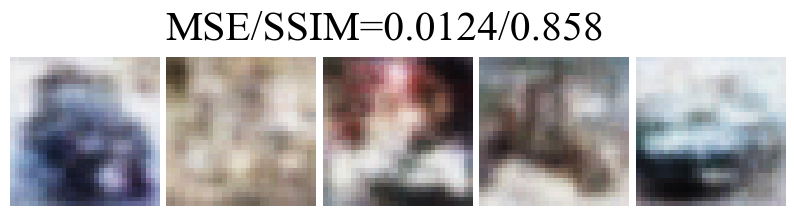

1:16 5th Epoch: 29/30

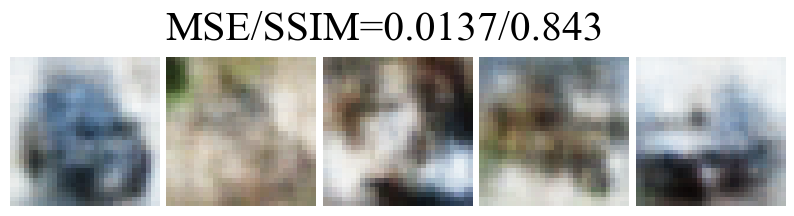

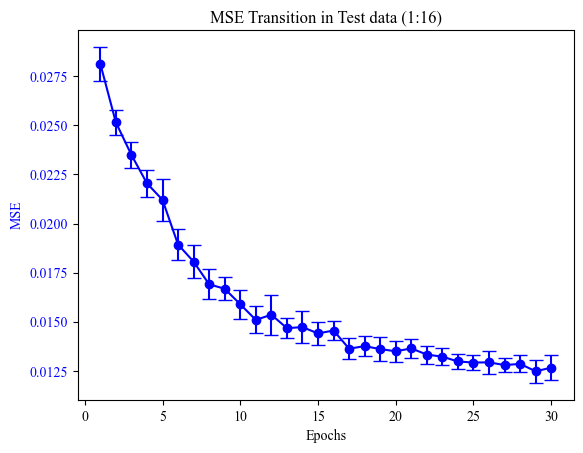

1:24 1th Epoch: 0/30

    Ratio Metrics   Average  Best ID      Best  Worst ID     Worst
0  (1:16)    SSIM  0.854364        3  0.866242         5  0.843285
1  (1:16)     MSE  0.012666        3  0.011772         5  0.013678
     Index  Processing Time
0        1       692.582834
1        2       704.108220
2        3       699.719178
3        4       692.133991
4        5       689.761755
   Average       695.661196


1:24 1th Epoch: 29/30

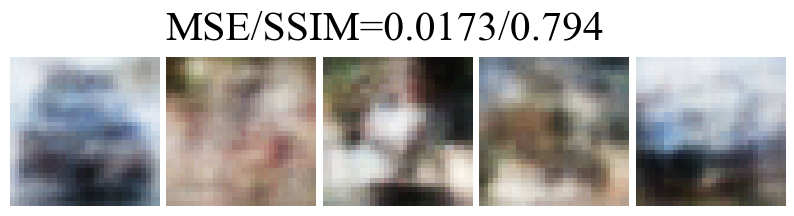

1:24 2th Epoch: 29/30

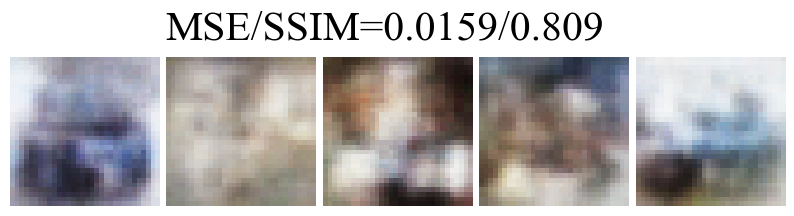

1:24 3th Epoch: 29/30

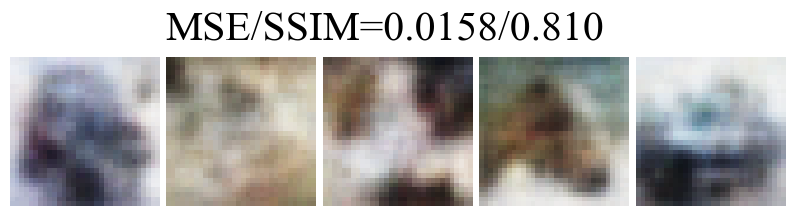

1:24 4th Epoch: 29/30

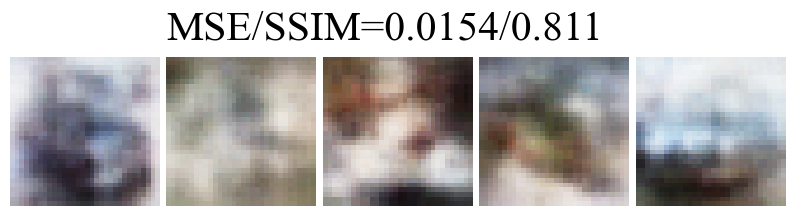

1:24 5th Epoch: 29/30

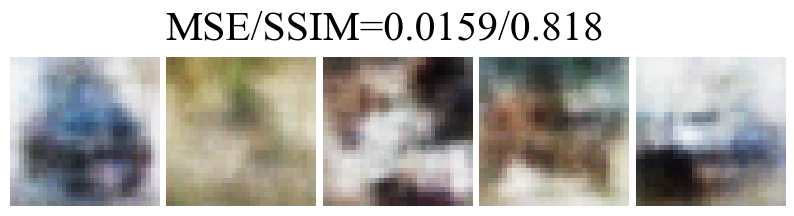

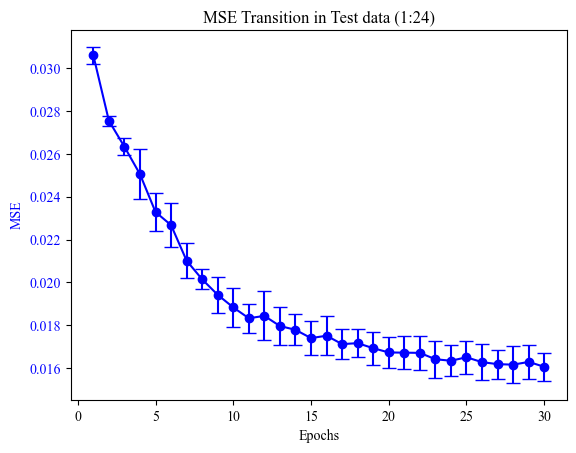

1:32 1th Epoch: 0/30

    Ratio Metrics   Average  Best ID      Best  Worst ID     Worst
0  (1:24)    SSIM  0.808689        5  0.818052         1  0.794474
1  (1:24)     MSE  0.016067        4  0.015361         1  0.017331
     Index  Processing Time
0        1       644.262244
1        2       567.441964
2        3       527.795434
3        4       527.594315
4        5       527.633825
   Average       558.945556


1:32 1th Epoch: 29/30

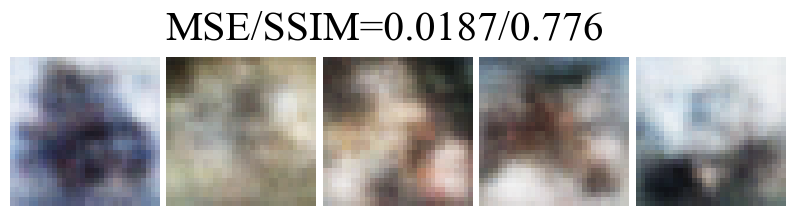

1:32 2th Epoch: 29/30

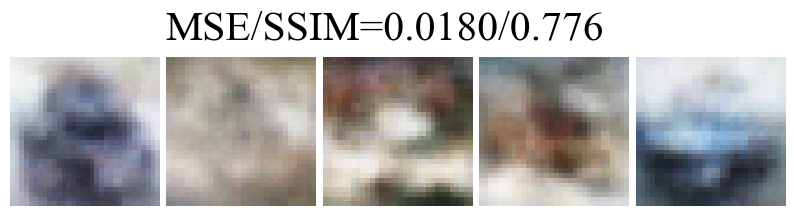

1:32 3th Epoch: 29/30

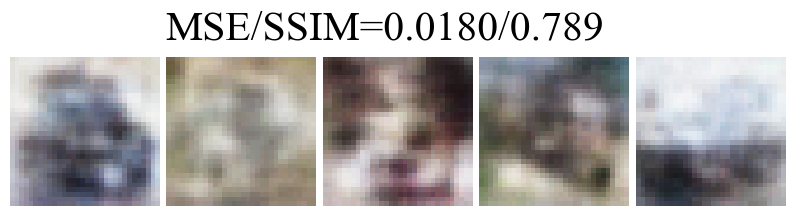

1:32 4th Epoch: 29/30

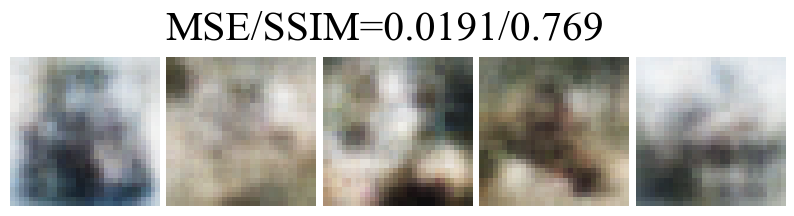

1:32 5th Epoch: 29/30

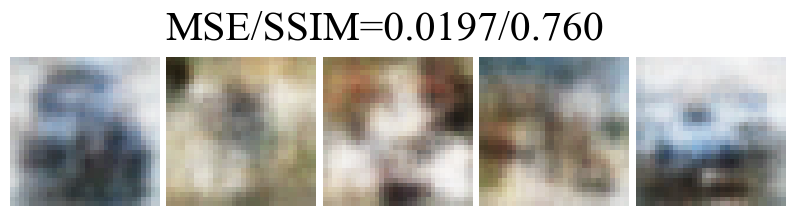

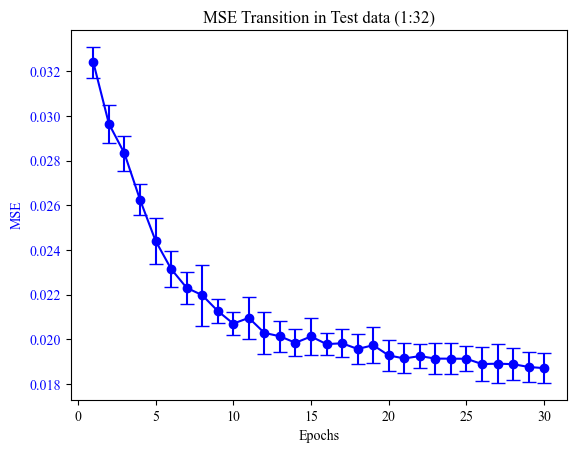

1:48 1th Epoch: 0/30

    Ratio Metrics   Average  Best ID      Best  Worst ID     Worst
0  (1:32)    SSIM  0.773914        3  0.788638         5  0.760037
1  (1:32)     MSE  0.018715        3  0.018006         5  0.019750
     Index  Processing Time
0        1       541.568917
1        2       534.029637
2        3       547.474634
3        4       547.887288
4        5       549.049738
   Average       544.002043


1:48 1th Epoch: 29/30

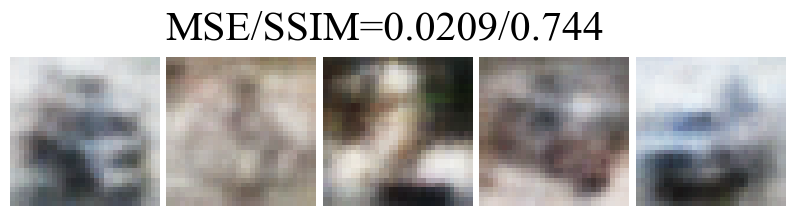

1:48 2th Epoch: 29/30

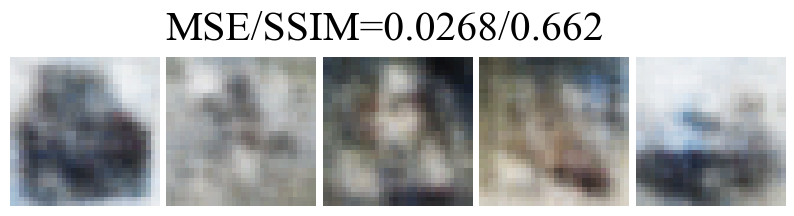

1:48 3th Epoch: 29/30

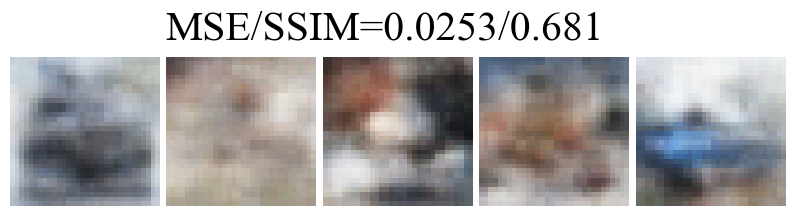

1:48 4th Epoch: 29/30

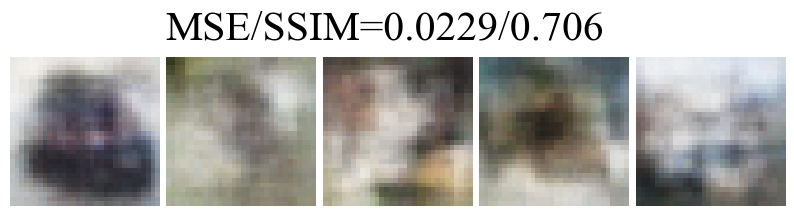

1:48 5th Epoch: 29/30

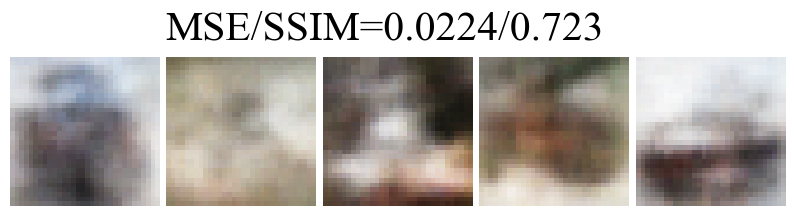

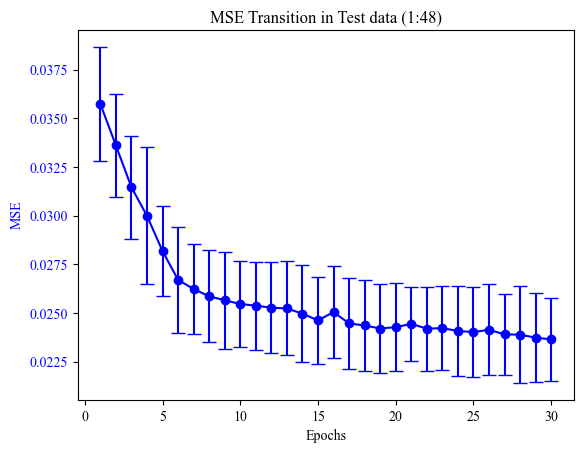

1:64 1th Epoch: 0/30

    Ratio Metrics   Average  Best ID      Best  Worst ID     Worst
0  (1:48)    SSIM  0.703111        1  0.744472         2  0.661589
1  (1:48)     MSE  0.023648        1  0.020901         2  0.026818
     Index  Processing Time
0        1       547.817513
1        2       546.018818
2        3       545.850471
3        4       550.106181
4        5       550.155355
   Average       547.989668


1:64 1th Epoch: 29/30

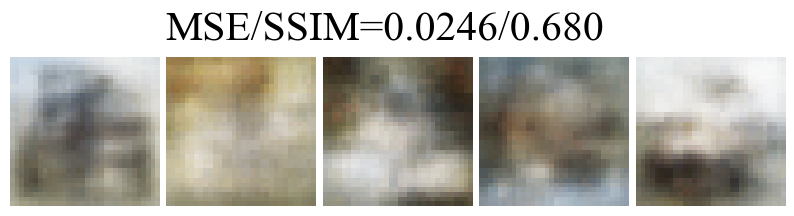

1:64 2th Epoch: 29/30

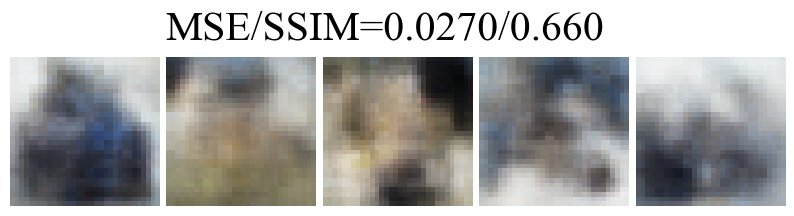

1:64 3th Epoch: 29/30

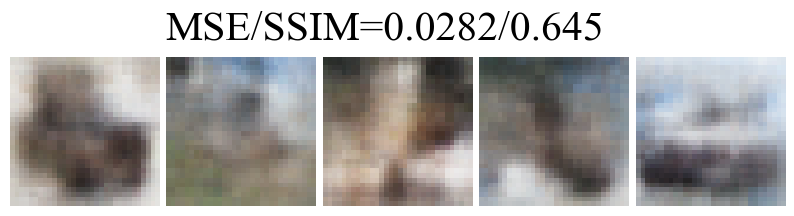

1:64 4th Epoch: 29/30

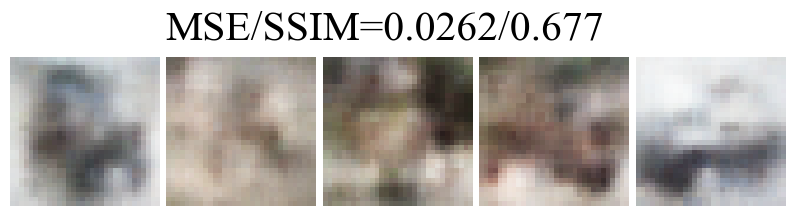

1:64 5th Epoch: 29/30

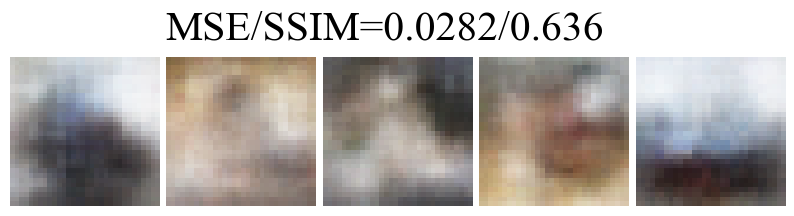

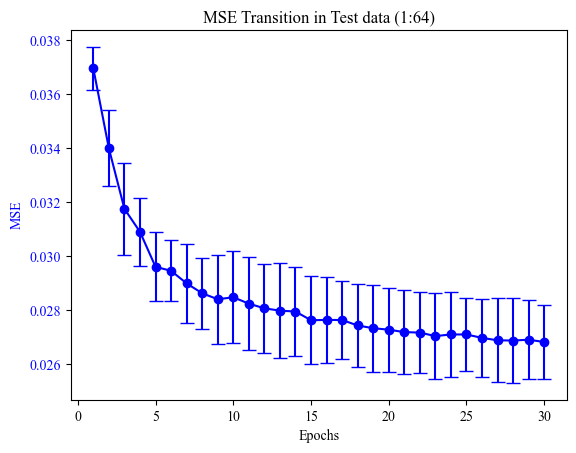

1:96 1th Epoch: 0/30

    Ratio Metrics   Average  Best ID      Best  Worst ID     Worst
0  (1:64)    SSIM  0.659533        1  0.679858         5  0.636418
1  (1:64)     MSE  0.026826        1  0.024557         5  0.028219
     Index  Processing Time
0        1       533.169553
1        2       525.732419
2        3       525.613250
3        4       526.018063
4        5       545.102380
   Average       531.127133


1:96 1th Epoch: 29/30

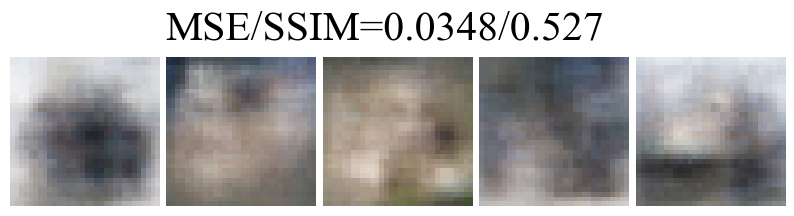

1:96 2th Epoch: 29/30

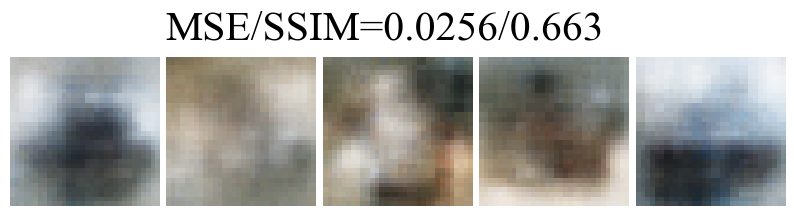

1:96 3th Epoch: 29/30

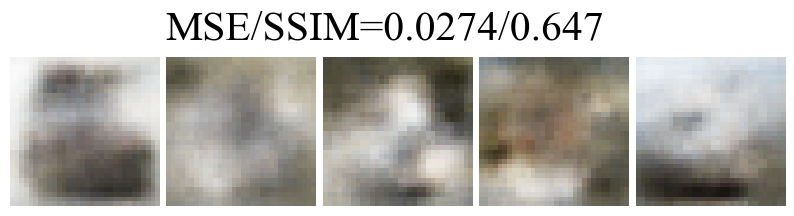

1:96 4th Epoch: 29/30

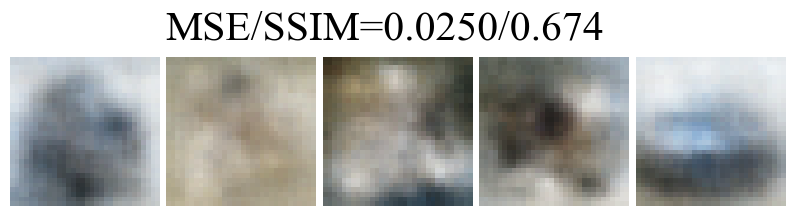

1:96 5th Epoch: 29/30

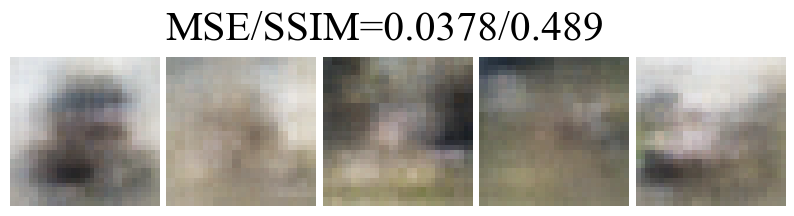

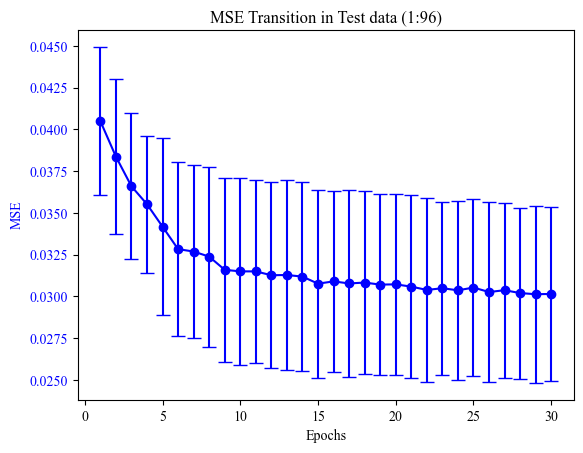

1:192 1th Epoch: 0/30

    Ratio Metrics   Average  Best ID      Best  Worst ID     Worst
0  (1:96)    SSIM  0.599848        4  0.674082         5  0.489321
1  (1:96)     MSE  0.030147        4  0.025039         5  0.037832
     Index  Processing Time
0        1       560.663855
1        2       571.505317
2        3       563.209581
3        4       613.012885
4        5       557.251724
   Average       573.128673


1:192 1th Epoch: 29/30

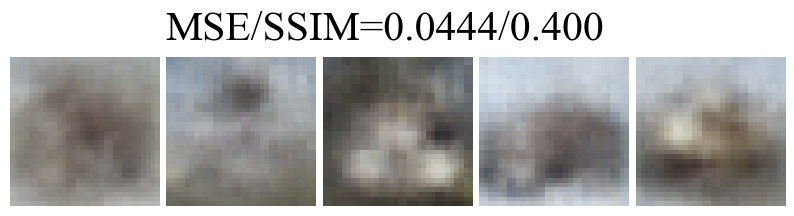

1:192 2th Epoch: 29/30

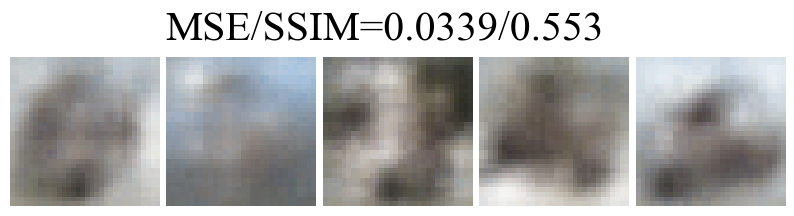

1:192 3th Epoch: 29/30

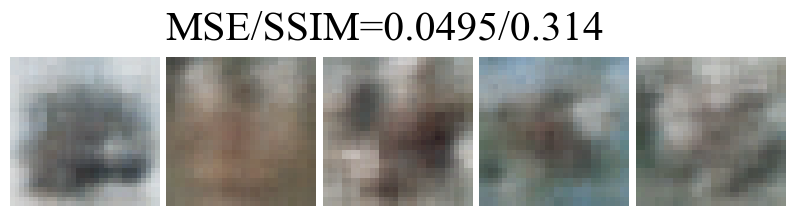

1:192 4th Epoch: 29/30

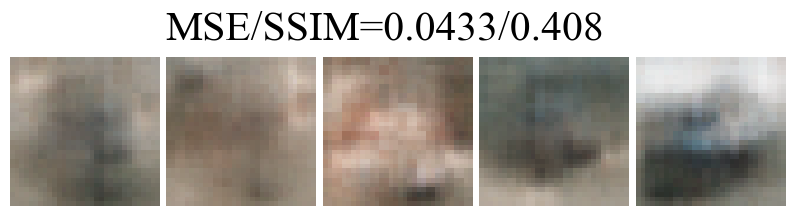

1:192 5th Epoch: 29/30

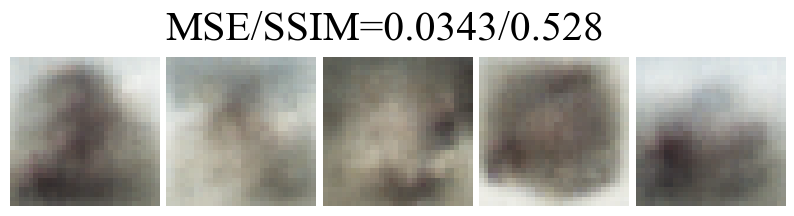

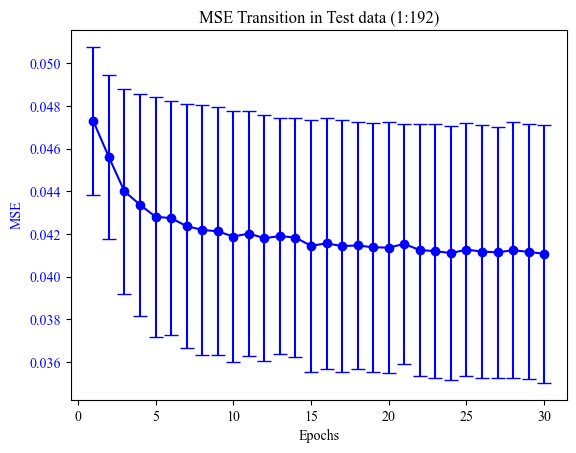

     Ratio Metrics   Average  Best ID      Best  Worst ID     Worst
0  (1:192)    SSIM  0.440600        2  0.553158         3  0.313730
1  (1:192)     MSE  0.041072        2  0.033945         3  0.049471
     Index  Processing Time
0        1       571.923799
1        2       663.182714
2        3       626.773657
3        4       776.523817
4        5       773.776631
   Average       682.436123


In [28]:
img_size = 32
channels = 3

DofIN = channels*img_size**2 ##CIFAR10 32*32*3
#leverage = 8 ##圧縮倍率
kernel_size = 8 #カーネルサイズ
ch = 64##64
pos_embed_dim = 8##16
max_epochs = 30#50

num_try = 5##5

leverages = [2,4,8,12,16,24,32,48,64,96,192] #[2,3,4,6,8,12,16,24,48]
results = []
All_last_MSEs_ = []
All_last_SSIMs_ = []

for leverage in leverages: 
    
    All_last_loss = []
    All_last_ssim = []
    All_loss_test = []
    All_pro_time = []

    for num_times in range(1,num_try+1): 

        model = AutoEncoder(img_size,channels,kernel_size,leverage,ch,pos_embed_dim).to(device)
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
        
        loss_train_ = []
        loss_test_ = []
        pro_time_ = []

                
        for epoch in range(max_epochs):

            sys.stderr.write('\r1:%d %dth Epoch: %d/%d' % (leverage,num_times, epoch, max_epochs)) 
            sys.stderr.flush()

            loss_train = 0
            loss_test = 0
            ssim_sum = 0

            start_time1 = time.time()
            for (x,t) in train_dataloader:
                        
                x, t = x.to(device), t.to(device)
                y = model(x).to(device)
                loss = criterion(y, x.view(x.size(0), -1)) 
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                loss_train += loss.item()
        
            loss_train_avg = loss_train / len(train_dataloader)
            end_time1 = time.time()
            pro_time_.append(end_time1-start_time1)


            with torch.no_grad():
                for x, t in test_dataloader:
                    x, t = x.to(device), t.to(device)
                    y = model(x).to(device)
                    loss = criterion(y, x.view(x.size(0), -1))
                    if epoch == max_epochs-1:
                        ssim_test = ssim_loss(y.view(-1, channels, img_size, img_size).cpu().numpy().transpose(0, 2, 3, 1), 
                                x.view(-1, channels, img_size, img_size).cpu().numpy().transpose(0, 2, 3, 1), 
                                channel_axis=-1,data_range=1.0)
                        ssim_sum += ssim_test
                    loss_test += loss.item()

            loss_test_avg = loss_test / len(test_dataloader)

            loss_train_.append(loss_train_avg)
            loss_test_.append(loss_test_avg)
            
            if epoch == max_epochs-1:
                All_loss_test.append(loss_test_)
                All_pro_time.append(sum(pro_time_)) 
                ssim_avg = ssim_sum / len(test_dataloader)

                All_last_ssim.append(ssim_avg) 
        Last_loss_test = loss_test_[-1]
        All_last_loss.append(Last_loss_test)#特定のleverageにおけるlastmse


        with torch.no_grad():
            test_images = test_images.to(device)
            reconstructed_images = model(test_images)
            image_title = "MSE/SSIM=%.4f/%.3f"%(Last_loss_test,ssim_avg)
            show_images(reconstructed_images.cpu(),test_labels, image_title)
            file_name = '%d_ReImage(1_%d)%dth.png'%(int(formatted_date),leverage,num_times)
            full_path = os.path.join(save_directory, file_name)
            plt.savefig(full_path, dpi=100, bbox_inches='tight')
            plt.show()

    All_last_MSEs_.append(All_last_loss)
    All_last_SSIMs_.append(All_last_ssim)

    epochs = len(All_loss_test[0]) 
    num_dimensions = len(All_loss_test)
    mean_loss = np.mean(All_loss_test, axis=0)
    std_loss = np.std(All_loss_test, axis=0)

    fig, ax1 = plt.subplots()

    ax1.errorbar(
        x=range(1, epochs + 1), y=mean_loss, yerr=std_loss,
        fmt='-o', color='blue', ecolor='blue', capsize=5, 
    )

    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('MSE', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    plt.title('MSE Transition in Test data (1:%d)' % leverage)
    file_name = '%d_MSE_errorbar(1_%d).png'%(int(formatted_date),leverage)
    full_path = os.path.join(save_directory, file_name)
    plt.savefig(full_path, dpi=100, bbox_inches='tight')
    plt.show()

    SSIM_mean = np.mean(All_last_ssim)
    SSIM_best = np.max(All_last_ssim)
    SSIM_bestID = np.argmax(All_last_ssim)+1
    SSIM_worst = np.min(All_last_ssim)
    SSIM_worstID = np.argmin(All_last_ssim)+1

    MSE_mean = np.mean(All_last_loss)
    MSE_best = np.min(All_last_loss)
    MSE_bestID = np.argmin(All_last_loss)+1
    MSE_worst = np.max(All_last_loss)
    MSE_worstID = np.argmax(All_last_loss)+1

    data = {
        "Ratio":["(1:%d)"%(leverage),"(1:%d)"%(leverage)],
        "Metrics": ["SSIM", "MSE"],
        "Average": [SSIM_mean, MSE_mean,],
        "Best ID": [SSIM_bestID, MSE_bestID,],
        "Best": [SSIM_best, MSE_best],
        "Worst ID": [SSIM_worstID, MSE_worstID],
        "Worst": [SSIM_worst, MSE_worst],
    }
    df = pd.DataFrame(data)
    results.append(data)
    print(df)

    pro_time_mean = sum(All_pro_time)/len(All_pro_time)
    data2 = {
        "Index": list(range(1, len(All_pro_time) + 1)),  # インデックス（1から開始）
        "Processing Time": All_pro_time                # 各処理時間
    }
    df2 = pd.DataFrame(data2)
    df2.loc[""] = ["Average", pro_time_mean]
    print(df2)


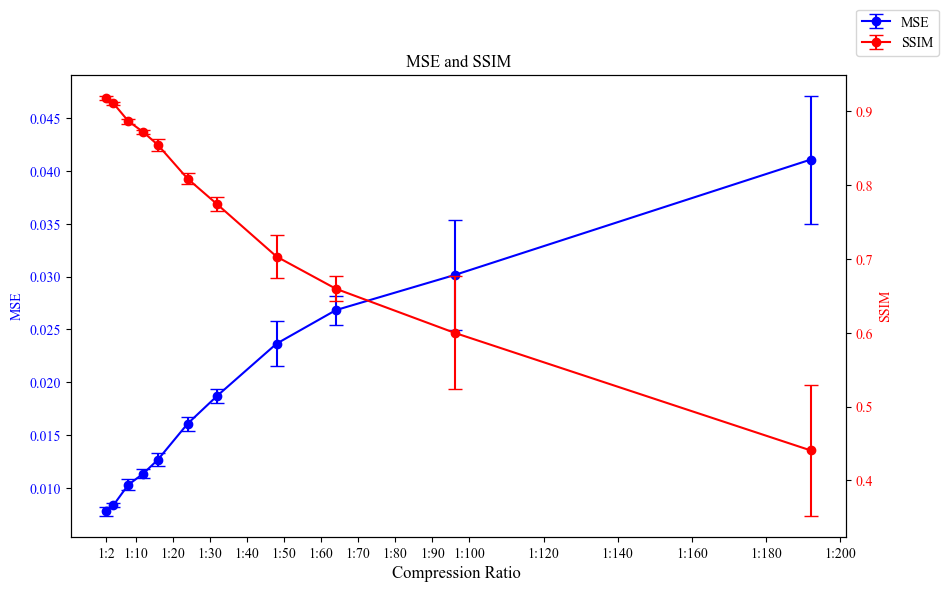

In [29]:
# 横軸の値 (1/leverage)
x_values = [leverage for leverage in leverages]
memory_lis =[2,10,20,30,40,50,60,70,80,90,100,120,140,160,180,200]

# MSE用の平均値と標準偏差を計算
mse_means = [np.mean(mse_list) for mse_list in All_last_MSEs_]
mse_stds = [np.std(mse_list) for mse_list in All_last_MSEs_]

# SSIM用の平均値と標準偏差を計算
ssim_means = [np.mean(ssim_list) for ssim_list in All_last_SSIMs_]
ssim_stds = [np.std(ssim_list) for ssim_list in All_last_SSIMs_]

# グラフの描画
fig, ax1 = plt.subplots(figsize=(10, 6))

# MSEのエラーバー付き折れ線グラフ
ax1.errorbar(
    x=x_values, y=mse_means, yerr=mse_stds,
    fmt='-o', color='blue', ecolor='blue', capsize=5, label='MSE'
)
ax1.set_ylabel('MSE', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
# SSIMのエラーバー付き折れ線グラフ
ax2.errorbar(
    x=x_values, y=ssim_means, yerr=ssim_stds,
    fmt='-o', color='red', ecolor='red', capsize=5, label='SSIM'
)
ax2.set_ylabel('SSIM', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# 軸ラベルとスケールの設定
ax1.set_xlabel('Compression Ratio ', fontsize=12)

ax1.set_xticks(memory_lis)
ax1.set_xticklabels([f"1:{x}" for x in memory_lis]) # ラベルを「1:N」形式で表示

# タイトルと凡例
plt.title('MSE and SSIM', fontsize=14)
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
fig.legend(
    lines1 + lines2, labels1 + labels2, loc="upper right", bbox_to_anchor=(1, 1)
)


title = 'MSE and SSIM' #
plt.title(title)
file_name = '%d_MSEandSSIM.png'%(int(formatted_date))
full_path = os.path.join(save_directory, file_name)
plt.savefig(full_path, dpi=100, bbox_inches='tight')
plt.show()

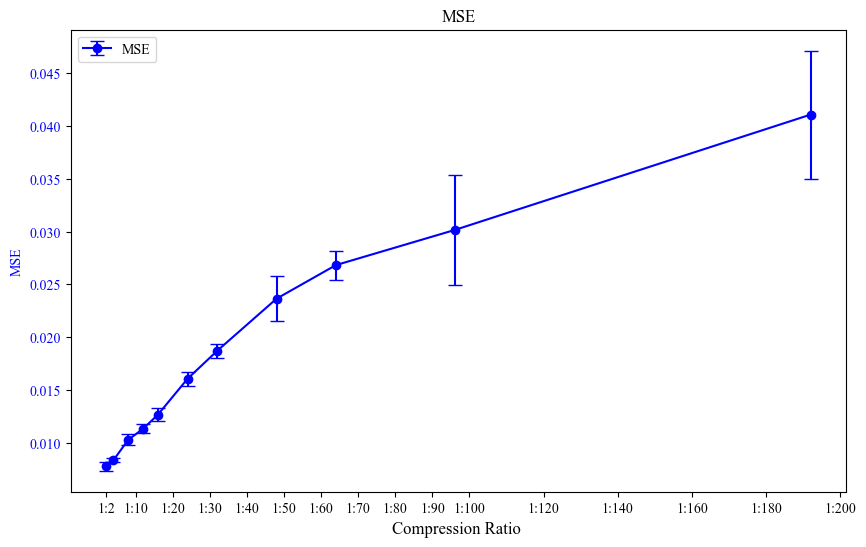

In [30]:
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.errorbar(
    x=x_values, y=mse_means, yerr=mse_stds,
    fmt='-o', color='blue', ecolor='blue', capsize=5, label='MSE'
)
ax1.set_ylabel('MSE', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax1.set_xlabel('Compression Ratio ', fontsize=12)
ax1.set_xticks(memory_lis)
ax1.set_xticklabels([f"1:{x}" for x in memory_lis])

ax1.legend()
title = 'MSE' #
plt.title(title)
file_name = '%d_MSEperRatio.png'%(int(formatted_date))
full_path = os.path.join(save_directory, file_name)
plt.savefig(full_path, dpi=100, bbox_inches='tight')
plt.show()

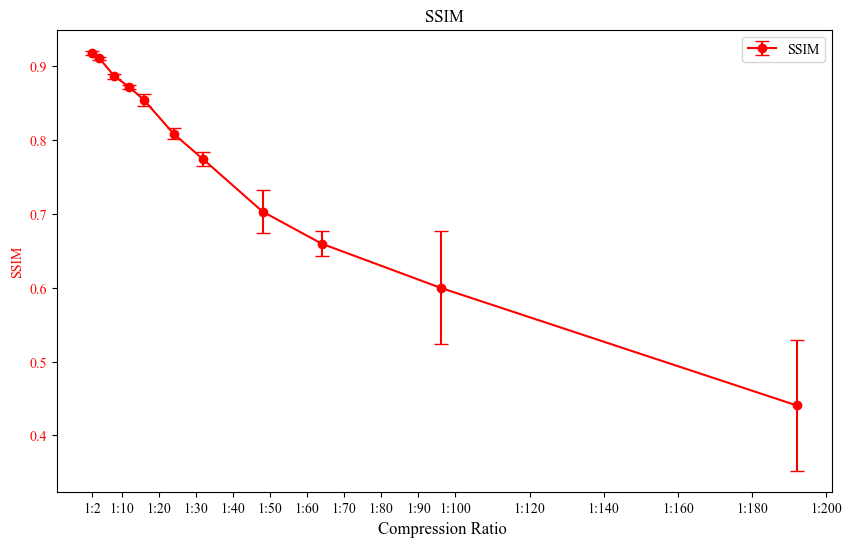

In [31]:
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.errorbar(
    x=x_values, y=ssim_means, yerr=ssim_stds,
    fmt='-o', color='red', ecolor='red', capsize=5, label='SSIM'
)
ax1.set_ylabel('SSIM', color='red')
ax1.tick_params(axis='y', labelcolor='red')

ax1.set_xlabel('Compression Ratio ', fontsize=12)
ax1.set_xticks(memory_lis)
ax1.set_xticklabels([f"1:{x}" for x in memory_lis])

ax1.legend()
title = 'SSIM' #
plt.title(title)
file_name = '%d_SSIMperRatio.png'%(int(formatted_date))
full_path = os.path.join(save_directory, file_name)
plt.savefig(full_path, dpi=100, bbox_inches='tight')
plt.show()

In [32]:
all_data = pd.concat([pd.DataFrame(result) for result in results], ignore_index=True)
print(all_data)
file_name = '%d_exTable.csv'%(int(formatted_date))
full_path = os.path.join(save_directory, file_name)
all_data.to_csv(full_path, index=False)

      Ratio Metrics   Average  Best ID      Best  Worst ID     Worst
0     (1:2)    SSIM  0.917878        1  0.923235         4  0.914433
1     (1:2)     MSE  0.007786        1  0.007108         2  0.008341
2     (1:4)    SSIM  0.910779        2  0.912442         4  0.907613
3     (1:4)     MSE  0.008354        2  0.007963         4  0.008637
4     (1:8)    SSIM  0.886709        3  0.889866         1  0.880579
5     (1:8)     MSE  0.010287        3  0.009935         1  0.011336
6    (1:12)    SSIM  0.872050        3  0.874799         4  0.866912
7    (1:12)     MSE  0.011329        3  0.010818         4  0.012039
8    (1:16)    SSIM  0.854364        3  0.866242         5  0.843285
9    (1:16)     MSE  0.012666        3  0.011772         5  0.013678
10   (1:24)    SSIM  0.808689        5  0.818052         1  0.794474
11   (1:24)     MSE  0.016067        4  0.015361         1  0.017331
12   (1:32)    SSIM  0.773914        3  0.788638         5  0.760037
13   (1:32)     MSE  0.018715     

In [33]:
import csv
save_directory1 = os.path.join(onedrive_path,'CODES', 'konishi_AutoEncoder', 'AutoEncoder_data005','texts') 
print(save_directory1)
os.makedirs(save_directory1, exist_ok=True)
file_name = 'CIFAR10_VCR_CIM-1C_list.csv'##
full_path = os.path.join(save_directory1, file_name)
with open(full_path, mode='w', newline='') as file:
    writer = csv.writer(file)

    writer.writerow(All_last_MSEs_)
    writer.writerow(All_last_SSIMs_)

C:\Users\Scent\OneDrive\CODES\konishi_AutoEncoder\AutoEncoder_data005\texts
